# TITLE 

## By Sarah Prusaitis, Rick Lataille, and Allison Ward

## Overview
overview/project intro here

## Business Problem
business problem paragraph here

## Data Limitations
data limitations info here

# EDA

In [2]:
import pandas as pd
import numpy as np

#import matplotlib.pyplot as plt 
#import seaborn as sns

import re
import string
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer, word_tokenize, regexp_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

#import gensim
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#import lightgbm as lgb

In [3]:
#! pip install gensim

In [4]:
#! pip install nltk

In [5]:
# Read original data
df1 = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'ISO-8859-1')

In [6]:
# Read synthetic data
df2 = pd.read_csv('data/Apple_Product_Negative_ Tweets_Sheet1.csv', encoding = 'ISO-8859-1')

In [7]:
# Rename columns for simplicity
df1 = df1.rename(columns = {'tweet_text': 'tweet', 
                         'emotion_in_tweet_is_directed_at': 'product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'})

In [8]:
# Combine rows into a single DataFrame
df = pd.concat([df1, df2], ignore_index = True)

In [9]:
df['tweet'] = df['tweet'].astype(str)

In [10]:
def replace_emoticons(text):
    # Define a dictionary mapping emoticons to their corresponding meanings
    emoticon_mapping = {
        ':D': 'emojismile',
        ':)': 'emojismile',
        ':-D': 'emojismile',
        ':\'': 'emojiunsure',
        ':p': 'emojitongue',
        ':P': 'emojitongue',
        ':(': 'emojisad'
        # Add more emoticons and their meanings as needed
    }
    pattern = re.compile('|'.join(re.escape(emoticon) for emoticon in emoticon_mapping.keys()))
    
    def replace(match):
        return emoticon_mapping[match.group(0)]

    return pattern.sub(replace, text)

In [11]:
# Replace emoticons with mapped strings
df['tweet'] = df['tweet'].apply(replace_emoticons)

In [12]:
def preprocess_tweet(tweet):
    # Remove links and mentions
    tweet = re.sub(r'http\S+|@\S+', '', tweet)
    
    # Remove {link}
    tweet = re.sub(r'\{link\}', '', tweet)
    
    # Replace &quot; with "
    tweet = tweet.replace('&quot;', '"')
    
    # Remove extra space between quotation mark and words
    tweet = re.sub(r'\s+"', '"', tweet)
    tweet = re.sub(r'"\s+', '"', tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove punctuation
    tweet = re.sub(r'([^\w\s]|_)+', ' ', tweet)
    
    # Tokenize
    tokens = nltk.word_tokenize(tweet)
    
    # Part-of-speech tagging
    tagged_tokens = nltk.pos_tag(tokens)
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for word, pos in tagged_tokens:
        if pos.startswith('J'):
            pos = 'a'  # Adjective
        elif pos.startswith('V'):
            pos = 'v'  # Verb
        elif pos.startswith('N'):
            pos = 'n'  # Noun
        elif pos.startswith('R'):
            pos = 'r'  # Adverb
        else:
            pos = 'n'  # Default to noun
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_tokens.append(lemma)
    
    # Add additional stopwords
    additional_stopwords = {'w', 'u', 'amp', 'sxsw', 'rt', 'apple', 'iphone', 'ipad'}  # amp = & 
    stop_words = set(stopwords.words('english')) | additional_stopwords
    
    # Remove stopwords
    tweet = [word for word in tokens if word not in stop_words]
    
    return tweet

In [13]:
#nltk.download('punkt')

In [14]:
#nltk.download('averaged_perceptron_tagger')

In [15]:
#nltk.download('wordnet')

In [16]:
#pip install --upgrade nltk

In [17]:
#nltk.download('stopwords')

In [18]:
df['tweet'] = df['tweet'].astype(str).apply(preprocess_tweet)

In [19]:
# Combined and renamed Apple products and non Apple products 

df['product'] = df['product'].replace({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Other',
    'Other Google product or service': 'Other',
    'Android App': 'Other',
    'Android': 'Other'
})
#there are 5802 rows that are null - what should we do with those?

In [20]:
# Filter DataFrame for only Apple tweets
df_apple = df[df['product']=='Apple'].reset_index(drop=True)

In [21]:
# Consolidate no emotion entries, and drop
df_apple['sentiment'] = df_apple['sentiment'].replace("I can't tell", "No emotion toward brand or product")
df_apple = df_apple.drop(df_apple[df_apple['sentiment'] == 'No emotion toward brand or product'].index).reset_index(drop=True)

In [22]:
# Label target with 1's and 0's
df_apple['target'] = df_apple['sentiment'].map({'Positive emotion': 1, 'Negative emotion': 0})

In [23]:
# train test split
X = df_apple['tweet']
y = df_apple['target'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [24]:
# Save tokenized data for Doc2Vec vectorizer
tokenized_train_data = X_train
tokenized_test_data = X_test

In [25]:
# Convert tokenized tweets back into strings for TfidfVectorizer
X_train_str = X_train.apply(lambda x: ' '.join(x))
X_test_str = X_test.apply(lambda x: ' '.join(x))

### TF-IDF Vectorization

In [26]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()  #ngram_range=(1,2)

# Fit and transform the vectorizer on the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

### Logistic Regression

In [27]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_tfidf, y_train)

LogisticRegression(random_state=42)

In [28]:
y_preds_lr = logreg.predict(X_train_tfidf)
y_test_preds_lr = logreg.predict(X_test_tfidf)

In [29]:
print(classification_report(y_train, y_preds_lr))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1511
           1       0.94      0.98      0.96      1539

    accuracy                           0.96      3050
   macro avg       0.96      0.96      0.96      3050
weighted avg       0.96      0.96      0.96      3050



In [30]:
print(classification_report(y_test,y_test_preds_lr))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       353
           1       0.90      0.90      0.90       410

    accuracy                           0.89       763
   macro avg       0.89      0.89      0.89       763
weighted avg       0.89      0.89      0.89       763



### Multinomial Naive Bayes

In [31]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [32]:
y_preds_nmb = mnb.predict(X_train_tfidf)
y_preds_test_nmb = mnb.predict(X_test_tfidf)

In [33]:
print(classification_report(y_train, y_preds_nmb))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1511
           1       0.93      0.98      0.95      1539

    accuracy                           0.95      3050
   macro avg       0.95      0.95      0.95      3050
weighted avg       0.95      0.95      0.95      3050



In [34]:
print(classification_report(y_test, y_preds_test_nmb))

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       353
           1       0.89      0.94      0.91       410

    accuracy                           0.90       763
   macro avg       0.90      0.90      0.90       763
weighted avg       0.90      0.90      0.90       763



### Support Vector Machines

In [35]:
#svc = SVC(random_state=42)
#svc.fit(X_train_tfidf, y_train)

In [36]:
#y_preds_svc = svc.predict(X_train_tfidf)
#y_preds_test_svc = svc.predict(X_test_tfidf)

In [37]:
#print(classification_report(y_train, y_preds_svc))

In [38]:
#print(classification_report(y_test, y_preds_test_svc))

In [39]:
'''
params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
          'degree':[2,3,4],
          'shrinking':[True,False],
         }
         '''

"\nparams = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],\n          'degree':[2,3,4],\n          'shrinking':[True,False],\n         }\n         "

In [40]:
#svc_grid = GridSearchCV(svc, param_grid=params, cv=5)

In [41]:
#start = time.time()
#svc_grid.fit(X_train_tfidf, y_train)
#end = time.time()
#print(f'{end-start} seconds')

In [42]:
#print(svc_grid.best_estimator_)
#print(svc_grid.best_params_)

In [43]:
#svc_tuned = SVC(degree=2, kernel='poly', shrinking=True, random_state=42)
#svc_tuned.fit(X_train_tfidf, y_train)

In [44]:
#y_preds_svc = svc_tuned.predict(X_train_tfidf)
#y_preds_test_svc = svc_tuned.predict(X_test_tfidf)

In [45]:
#print(classification_report(y_train, y_preds_svc))

In [46]:
#print(classification_report(y_test, y_preds_test_svc))

### Random Forest

In [47]:
#rf = RandomForestClassifier()
#rf.fit(X_train_tfidf, y_train)

In [48]:
#y_preds_rf = rf.predict(X_train_tfidf)
#y_preds_test_rf = rf.predict(X_test_tfidf)

In [49]:
#print(classification_report(y_train, y_preds_rf))

In [50]:
#print(classification_report(y_test, y_preds_test_rf))

In [51]:
'''
rf_params = {'n_estimators':[10, 50, 100],
             'criterion':['gini','entropy','log_loss'],
             'max_depth':[5,10,20]
            }
            '''

"\nrf_params = {'n_estimators':[10, 50, 100],\n             'criterion':['gini','entropy','log_loss'],\n             'max_depth':[5,10,20]\n            }\n            "

In [52]:
#rf_grid = GridSearchCV(rf, param_grid=rf_params, cv=5)

In [53]:
#rf_grid.fit(X_train_tfidf, y_train)

In [54]:
#print(rf_grid.best_estimator_)
#print(rf_grid.best_params_)

In [55]:
#rf2 = RandomForestClassifier(criterion='log_loss', max_depth=20, n_estimators=100)
#rf2.fit(X_train_tfidf, y_train)

In [56]:
#y_preds_rf2 = rf2.predict(X_train_tfidf)
#y_preds_test_rf2 = rf2.predict(X_test_tfidf)

In [57]:
#print(classification_report(y_train, y_preds_rf2))

In [58]:
#print(classification_report(y_test, y_preds_test_rf2))

### Doc2Vec Vectorization

In [59]:
# Tag tokenized_tweets with an index for identification
#tagged_train_data = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_train_data)]

# Initialize and train a Doc2Vec vectorizer
#start = time.time()
#vectorizer = Doc2Vec(tagged_train_data, vector_size=50, window=2, min_count=1, workers=4, epochs=40)
#end = time.time()
#print(f'{end-start} seconds')

In [60]:
# Infer vectors for testing set
#test_vectors = np.array([vectorizer.infer_vector(doc_tokens) for doc_tokens in tokenized_test_data])

In [61]:
#vectors = np.array([vectorizer.dv[i] for i in range(len(tagged_train_data))])

In [62]:
#train_data = lgb.Dataset(vectors, label=y_train.ravel())

In [63]:
'''
params = {'boosting_type': 'gbdt',  # Traditional Gradient Boosting Decision Tree
          'objective': 'binary',    # Binary classification
          'metric': ['binary_error'],  # Evaluation metrics
          'lambda_l1': 0.5,
          'lambda_l2': 0.5,
          'max_bin': 100,
          'num_leaves': 20,         # Number of leaves in full trees
          'learning_rate': 0.05,    # Learning rate
          'feature_fraction': 0.9,  # Fraction of features to be used at each iteration
          'bagging_fraction': 0.8,  # Fraction of data to be used for each iteration
          'bagging_freq': 5,        # Frequency for bagging
          'verbose': 1              # Verbose output in the terminal
}
'''

"\nparams = {'boosting_type': 'gbdt',  # Traditional Gradient Boosting Decision Tree\n          'objective': 'binary',    # Binary classification\n          'metric': ['binary_error'],  # Evaluation metrics\n          'lambda_l1': 0.5,\n          'lambda_l2': 0.5,\n          'max_bin': 100,\n          'num_leaves': 20,         # Number of leaves in full trees\n          'learning_rate': 0.05,    # Learning rate\n          'feature_fraction': 0.9,  # Fraction of features to be used at each iteration\n          'bagging_fraction': 0.8,  # Fraction of data to be used for each iteration\n          'bagging_freq': 5,        # Frequency for bagging\n          'verbose': 1              # Verbose output in the terminal\n}\n"

In [64]:
# Train the model
#num_round = 100  # Number of boosting rounds
#lgb_model = lgb.train(params, train_data, num_round)

In [65]:
# Make predictions and convert to binary
#y_preds_lgb = lgb_model.predict(vectors, num_iteration=lgb_model.best_iteration)
#y_preds_binary = [1 if prob > 0.5 else 0 for prob in y_preds_lgb]

#print(classification_report(y_preds_binary, y_train))

In [66]:
# Make predictions on test set
#y_preds_test_lgb = lgb_model.predict(test_vectors, num_iteration=lgb_model.best_iteration)
#y_preds_test_binary = [1 if prob > 0.5 else 0 for prob in y_preds_test_lgb]

#print(classification_report(y_preds_test_binary, y_test))

In [68]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 4.4 MB/s eta 0:00:00


In [70]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [71]:
positive_df = df_apple.loc[df_apple['target'] == 1].copy()
positive_df.head()

,tweet,product,sentiment,target
1,"[know, awesome, app, likely, appreciate, desig...",Apple,Positive emotion,1
2,"[wait, also, sale]",Apple,Positive emotion,1
4,"[beautifully, smart, simple, idea, wrote, holl...",Apple,Positive emotion,1
5,"[counting, days, plus, strong, canadian, dolla...",Apple,Positive emotion,1
6,"[great, app]",Apple,Positive emotion,1


In [72]:
def count_words_in_dataframe(df, column_name):
    word_count = {}
    for index, row in df.iterrows():
        words = row[column_name]
        for word in words:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
    return word_count


# Call the function
word_count_dict = count_words_in_dataframe(positive_df, 'tweet')

#print(word_count_dict)

# Convert the dictionary to a DataFrame
positive_word_count_df = pd.DataFrame.from_dict(word_count_dict, orient='index', columns=['count'])
positive_word_count_df.index.name = 'word'
positive_sorted_words = positive_word_count_df.sort_values(by='count', ascending=False)

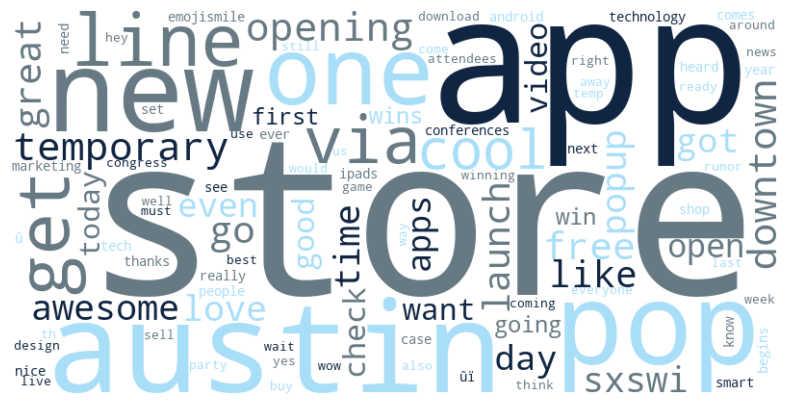

In [81]:
# Extract top 50 words and their counts
top_positive_words = positive_sorted_words.head(100)

# Convert the top words DataFrame to a dictionary
top_words_dict_pos = top_positive_words.to_dict()['count']

# Define custom colors
hex_colors = ['#677A84', '#102542', '#A9DEF9']

# Convert hexadecimal colors to RGB tuples
rgb_colors = [(int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)) for hex_color in hex_colors]

# Generate word cloud from the top words dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', color_func=lambda *args, **kwargs: rgb_colors[np.random.randint(0, len(rgb_colors))]).generate_from_frequencies(top_words_dict_pos)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [74]:
negative_df = df1.loc[df1['sentiment'] == 'Negative emotion'].copy()
negative_df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
17,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
38,@mention - False Alarm: Google Circles Not Co...,Google,Negative emotion
64,Again? RT @mention Line at the Apple store is ...,NaN,Negative emotion


In [75]:
negative_df['tweet'] = df['tweet'].astype(str)

#negative_df['tweet'] = df['tweet'].apply(replace_emoticons)

negative_df['tweet'] = df['tweet'].astype(str).apply(preprocess_tweet)

negative_df['product'] = df['product'].replace({
    'iPad': 'Apple',
    'Apple': 'Apple',
    'iPad or iPhone App': 'Apple',
    'iPhone': 'Apple',
    'Other Apple product or service': 'Apple',
    'Google': 'Other',
    'Other Google product or service': 'Other',
    'Android App': 'Other',
    'Android': 'Other'
})

# Filter DataFrame for only Apple tweets
negative_df = negative_df[negative_df['product']=='Apple'].reset_index(drop=True)
negative_df.head()

,tweet,product,sentiment
0,"[g, hrs, tweeting, rise, austin, dead, need, u...",Apple,Negative emotion
1,"[hope, year, festival, crashy, year, app]",Apple,Negative emotion
2,"[noticed, dst, coming, weekend, many, users, h...",Apple,Negative emotion
3,"[attending, design, headaches]",Apple,Negative emotion
4,"[provide, chargers, changed, mind, going, next...",Apple,Negative emotion


In [76]:
# Call the function
word_count_dict = count_words_in_dataframe(negative_df, 'tweet')

#print(word_count_dict)

# Convert the dictionary to a DataFrame
negative_word_count_df = pd.DataFrame.from_dict(word_count_dict, orient='index', columns=['count'])
negative_word_count_df.index.name = 'word'
sorted_negative_words = negative_word_count_df.sort_values(by='count', ascending=False)

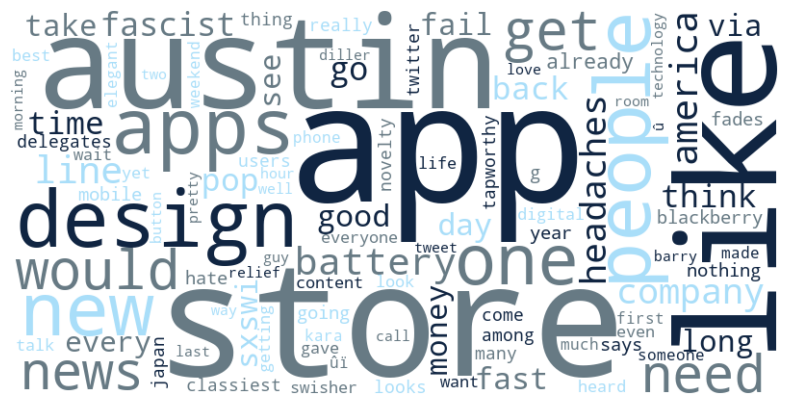

In [80]:
# Extract top 50 words and their counts
top_negative_words = sorted_negative_words.head(100)

# Convert the top words DataFrame to a dictionary
top_words_dict_neg = top_negative_words.to_dict()['count']

# Define custom colors
hex_colors = ['#677A84', '#102542', '#A9DEF9']

# Convert hexadecimal colors to RGB tuples
rgb_colors = [(int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)) for hex_color in hex_colors]

# Generate word cloud from the top words dictionary
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', color_func=lambda *args, **kwargs: rgb_colors[np.random.randint(0, len(rgb_colors))]).generate_from_frequencies(top_words_dict_neg)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()